## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

## Подготовка данных

In [1]:
# Подключение библиотек
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

#from pyspark.ml.tuning import CrossValidator
#from pyspark.ml.evaluation import BinaryClassificationEvaluator

RANDOM_SEED = 42
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Подключении к сесии Spark
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California Housing") \
                    .getOrCreate()

In [3]:
# считывайние файла 
df = spark.read.option('header', 'true') \
    .csv('/datasets/housing.csv', inferSchema = True)

In [4]:
# Схема и тип данных в dataframe
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



- longitude — широта;
- latitude — долгота;
- housing_median_age — медианный возраст жителей жилого массива;
- total_rooms — общее количество комнат в домах жилого массива;
- total_bedrooms — общее количество спален в домах жилого массива;
- population — количество человек, которые проживают в жилом массиве;
- households — количество домовладений в жилом массиве;
- median_income — медианный доход жителей жилого массива;
- median_house_value — медианная стоимость дома в жилом массиве;
- ocean_proximity — близость к океану.

In [5]:
# Находяться уникальные значения  в колонке ocean_proximity и колличество значений
print(df.select('ocean_proximity').distinct().toPandas()) # Отнесем к категориальному признаку
display(df.groupBy('ocean_proximity').count().toPandas()) # Находим кооличество отдаленных  от океана мест 
display(df.show(5))

  ocean_proximity
0          ISLAND
1      NEAR OCEAN
2        NEAR BAY
3       <1H OCEAN
4          INLAND


,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2658
2,NEAR BAY,2290
3,<1H OCEAN,9136
4,INLAND,6551


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

None

In [6]:
# приведенние типы данных к нужному (такие как колличество комнат и спален и т.д.)
colum = ['total_rooms', 'total_bedrooms', 'population',
          'households', 'median_house_value']
for _ in colum:
    df = df.withColumn(_, F.col(_).cast(IntegerType()))

df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [7]:
# Проверка не являеться ли ошибкой значение island (так как малая группа)
df.filter((df.ocean_proximity  == 'ISLAND')).toPandas() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.320,33.350,27.000,1675,521,744,331,2.158,450000,ISLAND
1,-118.330,33.340,52.000,2359,591,1100,431,2.833,414700,ISLAND
2,-118.320,33.330,52.000,2127,512,733,288,3.391,300000,ISLAND
3,-118.320,33.340,52.000,996,264,341,160,2.736,450000,ISLAND
4,-118.480,33.430,29.000,716,214,422,173,2.604,287500,ISLAND


- Просмотрев по координатам (долготы и широте) можно увидеть то что да это сооветсвует острову Санта-Каталина

In [8]:
# нахождение Нулевых значений и колличество данных значений
nan_table = df \
            .select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)) \
                     .alias(c) for c in df.columns]).toPandas().T.rename(columns={0:'NA'})
display(nan_table)

,NA
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [9]:
# Основная статистика по датасету
num_columns = ['housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households', 'median_income']
df.describe(num_columns).show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             20640|             20640|             20433|             20640|            20640|             20640|
|   mean|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|
| stddev| 12.58555761211163|2181.6152515827944|421.38507007403115|  1132.46212176534|382.3297528316098| 1.899821717945263|
|    min|               1.0|                 2|                 1|                 3|                1|            0.4999|
|    max|              52.0|             39320|              6445|             35682|             6082|           15.0001|
+-------+-------

In [10]:
quantile_lst = df.filter('total_bedrooms is NULL').approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)
quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])

display(quantile_df)

,quantile_25,quantile_50,quantile_75
0,19.000,30.000,38.000
1,1307.000,2155.000,3473.000
2,NaN,NaN,NaN
3,781.000,1217.000,1891.000
4,257.000,427.000,629.000
5,2.562,3.412,4.633


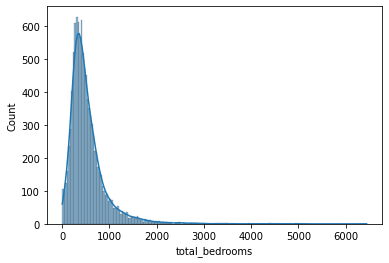

<AxesSubplot:xlabel='total_bedrooms'>

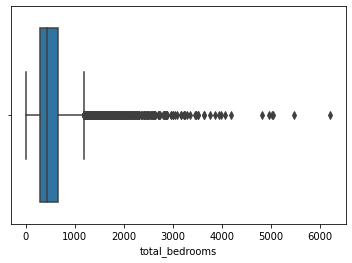

In [11]:
sns.histplot(data=df.sample(0.5).toPandas(), x="total_bedrooms", multiple="stack", kde=True)
plt.show()
sns.boxplot(data=df.sample(0.5).toPandas(), x="total_bedrooms")
# Заполняться медианным значением


Как видно из графиков медиана находиться где то на половине участка между 0 и 1000, и так же есть выбросы которые начинаються с 1200 и свыше 6000 данные значение не понятно как обработать так как это может быть высокоэтжный дом (с большим колличеством спален) и чтобы не смещать значения выбираеться вставить вместо пропусков медианное значение

In [12]:
# Расчёт медианы и замена значений медианным
df_tot_bed = df.approxQuantile('total_bedrooms',[0.5],0)[0]
print(f'Медианное значение колонки total bedrooms: {df_tot_bed}')
df = df.fillna(df_tot_bed, subset=['total_bedrooms'])

Медианное значение колонки total bedrooms: 435.0


23/02/22 10:07:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/22 10:07:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

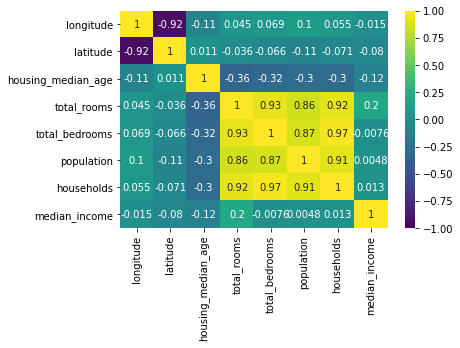

In [13]:
# Построение корреляционной матрицы 
corr_col = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households', 'median_income']

vector_col = 'corr_feat'
assembler = VectorAssembler(inputCols=corr_col, outputCol=vector_col)
df_vector = assembler.setHandleInvalid('skip').transform(df[corr_col]).select(vector_col)

#создаеться матрица
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()


matrix_df = pd.DataFrame(cor_np, columns=corr_col)
matrix_df.index = corr_col

sns.heatmap(matrix_df, annot=True, vmin=-1, vmax=1, cmap='viridis')

In [14]:
# разделение на feat and target
cat_features = 'ocean_proximity'
num_features = corr_col
target = 'median_house_value'

In [15]:
# Трансформация данных при помощи String Index
indexer = StringIndexer(inputCol=cat_features,
                        outputCol=cat_features+'_idx')
df = indexer.fit(df).transform(df)

# Проверка трансформации
cols = [c for c in df.columns if c.startswith(cat_features)]
df.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 3 rows



In [16]:
# Дополнительно используеться OHE коддирование
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                        outputCol=cat_features+'_ohe')
df = encoder.fit(df).transform(df)

cols = [c for c in df.columns if c.startswith(cat_features)]
df.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [17]:
# В преобразуется этот признак в один вектор
categorical_vect = \
    VectorAssembler(inputCols=['ocean_proximity_ohe'],
                    outputCol='categorical_features')
df = categorical_vect.transform(df)

# Проверка
df.toPandas().head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features
0,-122.230,37.880,41.000,880,129,322,126,8.325,452600,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
1,-122.220,37.860,21.000,7099,1106,2401,1138,8.301,358500,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
2,-122.240,37.850,52.000,1467,190,496,177,7.257,352100,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
3,-122.250,37.850,52.000,1274,235,558,219,5.643,341300,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"
4,-122.250,37.850,52.000,1627,280,565,259,3.846,342200,NEAR BAY,3.000,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0)"


### Вывод 
- Была инцилизированна Spark версия
- Исправленны типы данных
- Проверенны значения в колонке ocean_proxmity
- Построенна матрица корреляции по которой можно сказать наиболее корреляционными данными являються (всего комнат, семейство и всего спален ) это логично так как все комнат включает в себя  значения и спален.
- Проведена кодировка категариальных признаков OHE and StringIndex

## Обучение моделей

In [18]:
# Для значений которые имеют большие значения не смещали оценку используеться StanfardScaler
numerical_vect = VectorAssembler(inputCols=num_features,
                                      outputCol='numerical_features')
df = numerical_vect.transform(df)

standard_scaler = StandardScaler(inputCol='numerical_features',
                                 outputCol='numerical_features_scaled')
df = standard_scaler.fit(df).transform(df)
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- ocean_proximity_idx: double (nullable = false)
 |-- ocean_proximity_ohe: vector (nullable = true)
 |-- categorical_features: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- numerical_features_scaled: vector (nullable = true)



In [19]:
# Преобразование категориальных и численных признаков в один вектор
all_feat = ['categorical_features', 'numerical_features_scaled']
final_vect = VectorAssembler(inputCols=all_feat,
                                  outputCol='all_features')
df = final_vect.transform(df)
df.select('all_features').show(3)

+--------------------+
|        all_features|
+--------------------+
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
+--------------------+
only showing top 3 rows



In [20]:
# Разделение на обучающую и тестовую выборку
train, test = df.select(['all_features',
                                 'numerical_features_scaled',
                                 'median_house_value']).randomSplit([.75, .25], seed=RANDOM_SEED)
print(f'Обучающая выборка: {train.count()} строк, {len(train.columns)} столбцов',
      f'\nТестовая выборка:, {test.count()} строк, {len(test.columns)} столбцов')

Обучающая выборка: 15500 строк, 3 столбцов 
Тестовая выборка:, 5140 строк, 3 столбцов


In [21]:
# Создаем список, куда будут вноситься результаты
data_table = [['features_used', 'RMSE', 'MAE', 'R2']]

for col in ['all_features', 'numerical_features_scaled']:
    # обучаем модель
    lr = LinearRegression(featuresCol=col, labelCol=target)
    model = lr.fit(train)
    
    #запишем предсказания на тестовой выборке
    predictions = model.transform(test)
    
    #выделим предсказания и ответы в отдельную переменную
    results = predictions.select(['prediction', target])
    results = results.withColumn("median_house_value",results.median_house_value.cast('double'))
    metrics = RegressionMetrics(results.rdd) 

    #добавим результаты в список
    data_table.append([col,
                       metrics.rootMeanSquaredError,
                       metrics.meanAbsoluteError,
                       metrics.r2])

23/02/22 10:08:07 WARN Instrumentation: [7793004a] regParam is zero, which might cause numerical instability and overfitting.
23/02/22 10:08:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/22 10:08:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/02/22 10:08:13 WARN Instrumentation: [f0a70494] regParam is zero, which might cause numerical instability and overfitting.


### Вывод
- Используеться тстратификация данных (чтоб не происходило смещение оценок изза больших значений данных)
- Преобрахуються категориальных и численных признаков в один вектор all featureS  который последующем вноситься в dataframe
- Разделение тестовой и тренировочной выборки
- Обучение и предсказание и вывод модели 

## Анализ результатов

In [22]:
pd.DataFrame(data_table[1:], columns=data_table[0])

,features_used,RMSE,MAE,R2
0,all_features,67559.131,49365.353,0.660
1,numerical_features_scaled,68462.761,50316.784,0.651


Посмотрев на результаты указанных выше в таблице можно сказать то что:
- RMSE and MAE меньше у (тех значений которые использует все feat) Чем ниже RMSE тем та модель наиболее соотвествует dataframe
- Обучение надо проводить с совсеми фичамя 

## Вывод
Была построена модель линейной регресии, которая предсказывает медианное значение стоиости жилища в  Калифорнии 1990 года. Для предсказания данной модели надо испольоваться все features  которые могут помочь решить данную задачу. 

## Чек лист

- [x] Инициализируйте локальную Spark-сессию.
- [x] Прочитайте содержимое файла /datasets/housing.csv.
- [x] Выведите типы данных колонок датасета. Используйте методы pySpark.
- [x] Выполните предобработку данных:
 -  Исследуйте данные на наличие пропусков и заполните их, выбрав значения по своему усмотрению.
 -  Преобразуйте колонку с категориальными значениями техникой One hot encoding.
- [x] Постройте две модели линейной регрессии на разных наборах данных:
 -  используя все данные из файла;
 -  используя только числовые переменные, исключив категориальные.
- [x] Для построения модели используйте оценщик LinearRegression из библиотеки MLlib.
- [x] Сравните результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. Сделайте выводы.

In [25]:
spark.stop()